In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.4 MB/s eta 0:00:00


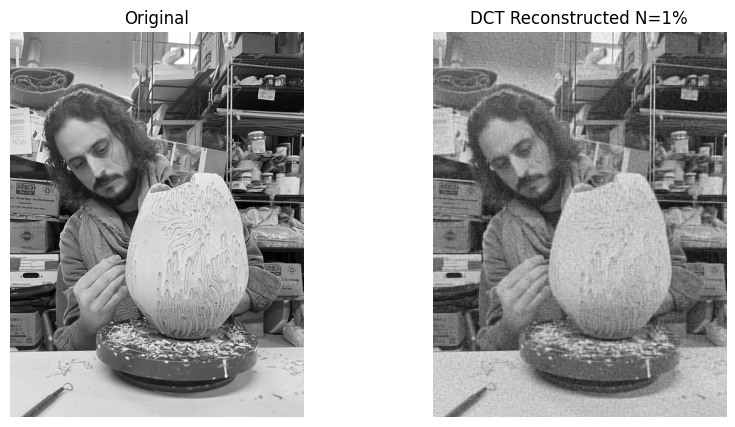

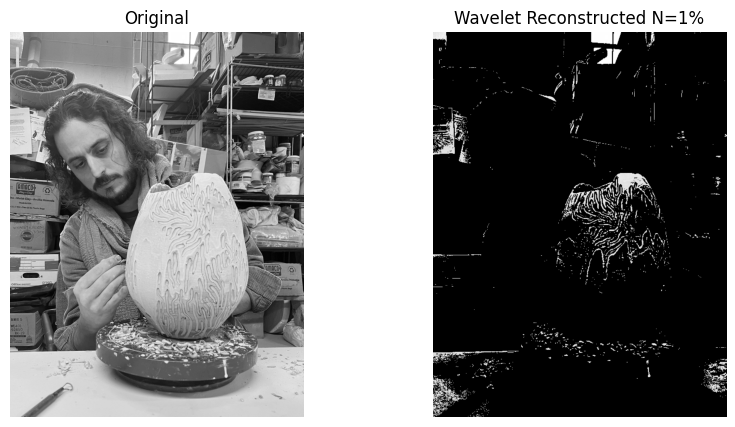

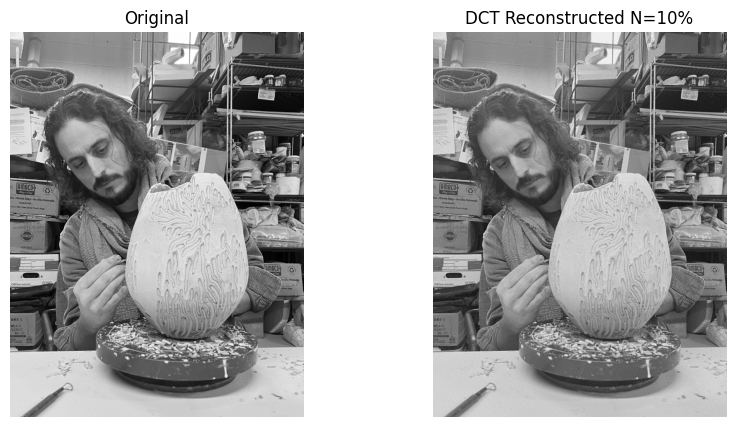

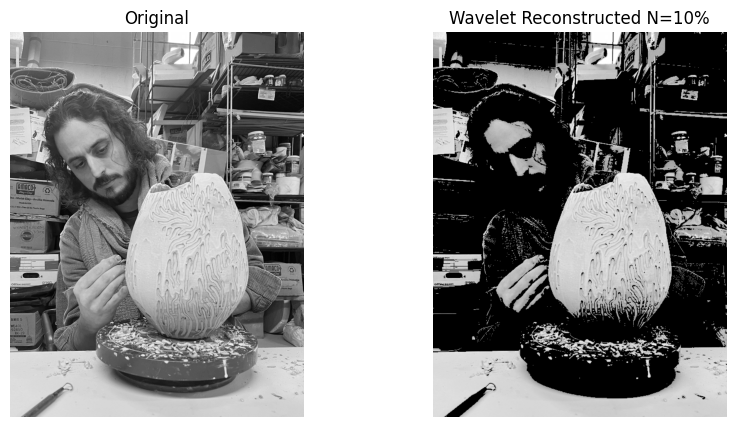

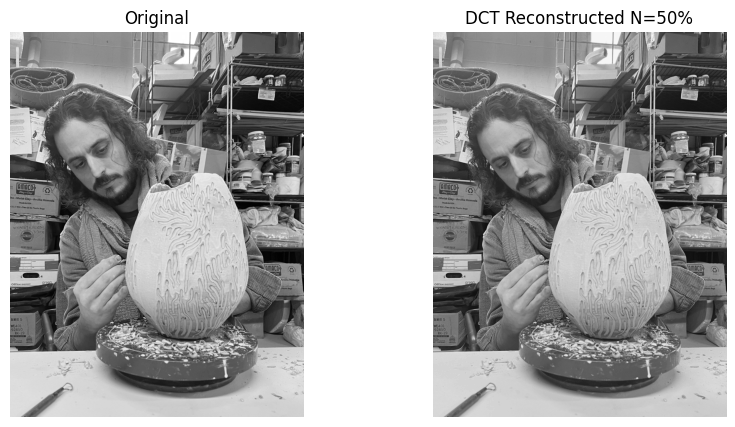

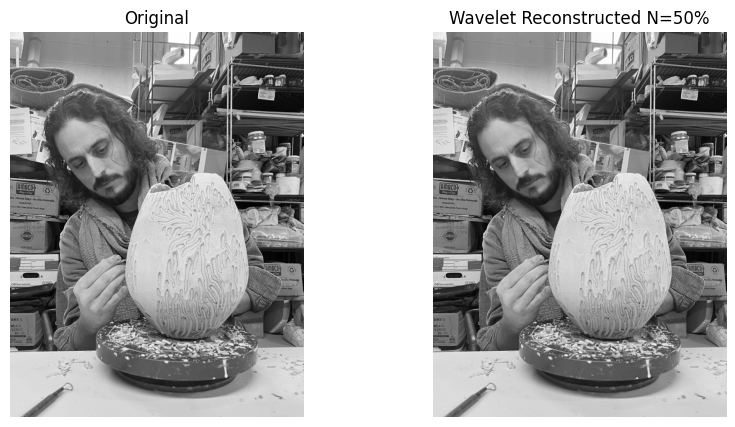

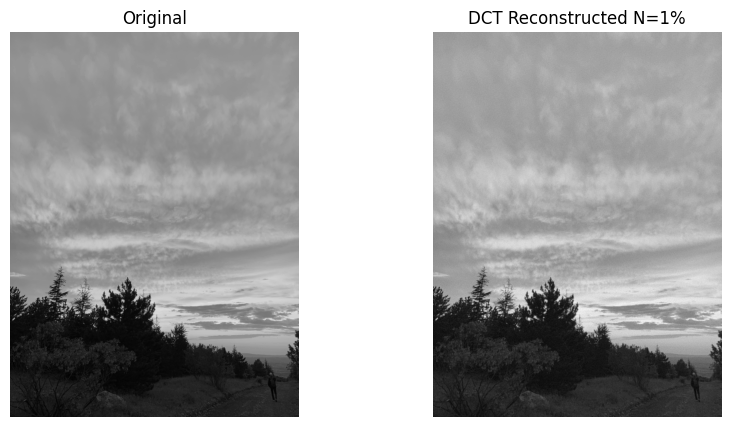

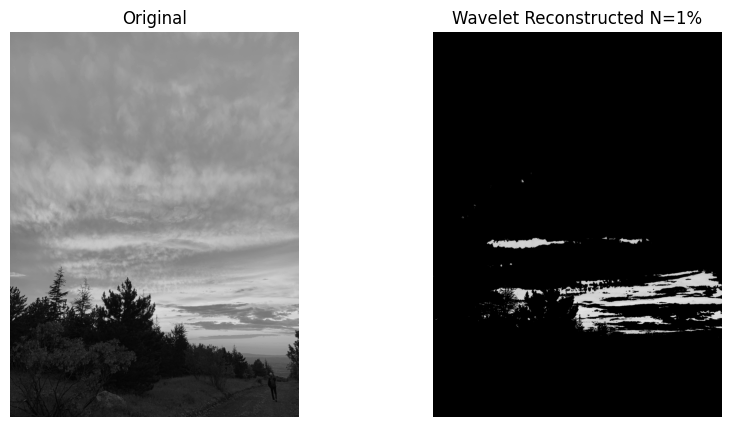

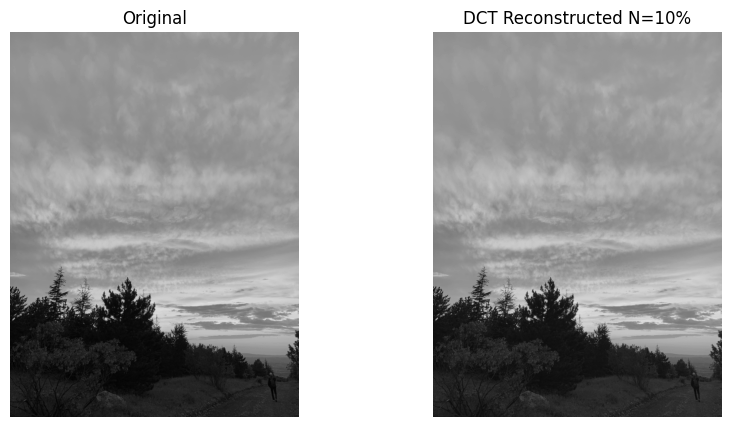

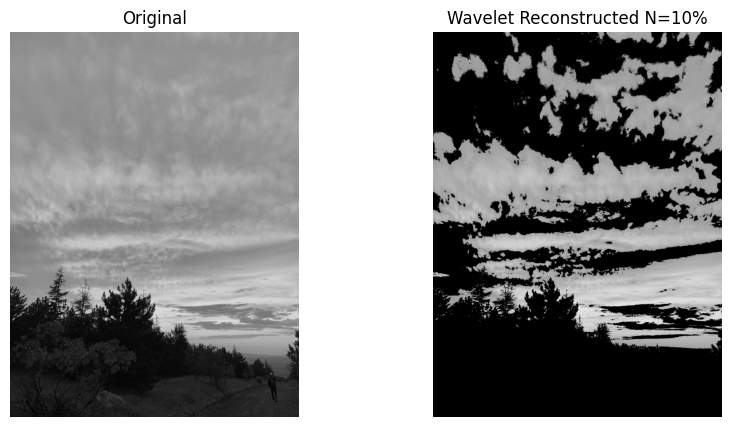

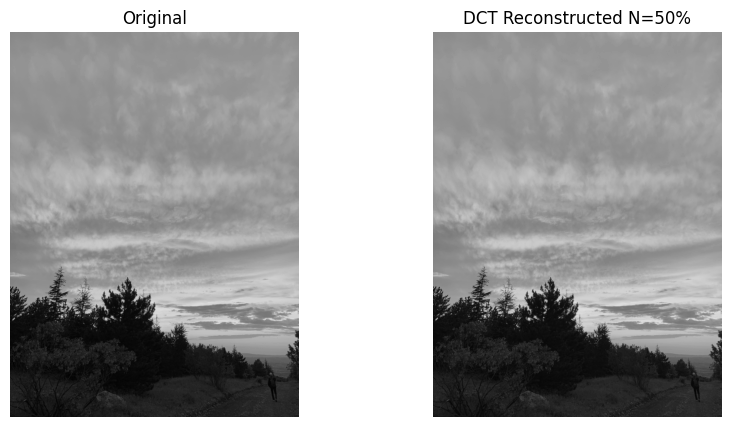

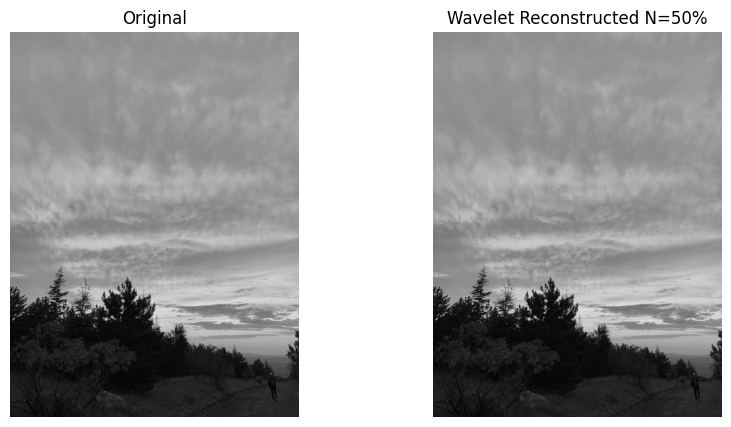

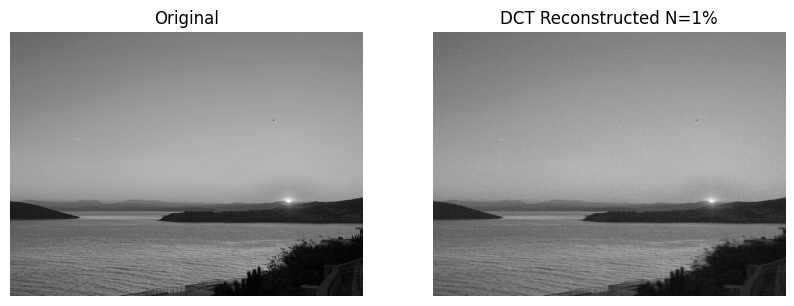

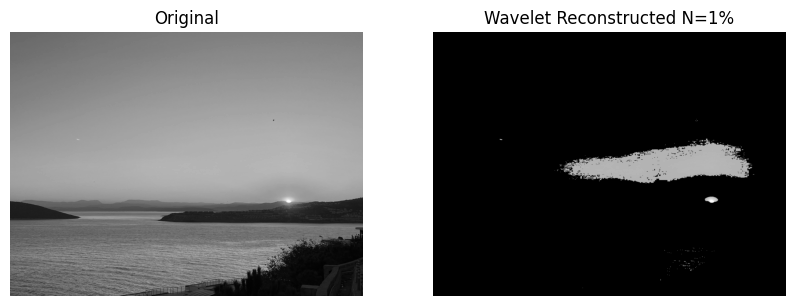

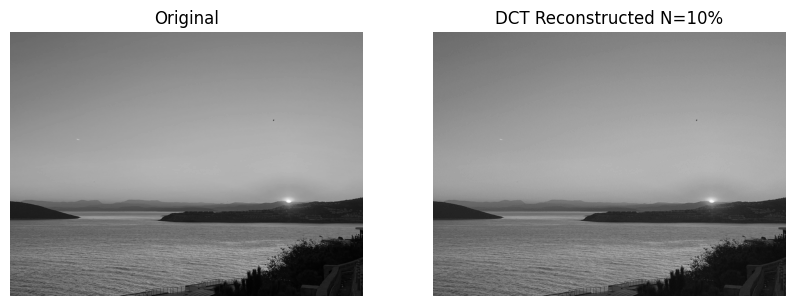

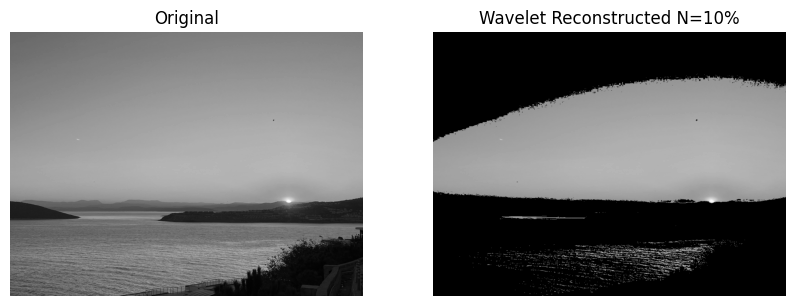

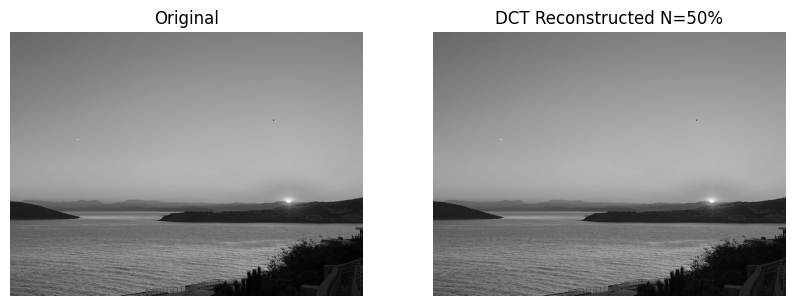

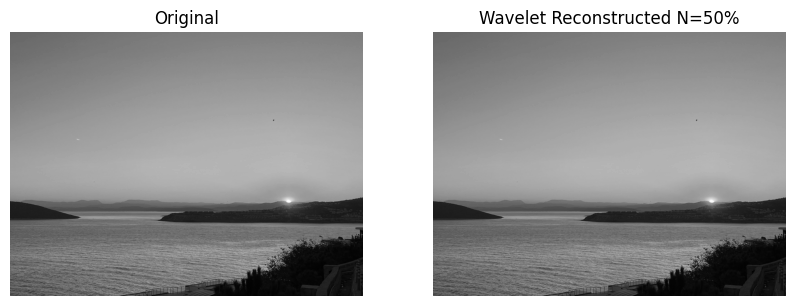

Results for c1:
  Compression Level N=1%:
    DCT -> MSE: 324.5169, Size: 405764 bytes
    Wavelet -> MSE: 19584.7267, Size: 209753 bytes
  Compression Level N=10%:
    DCT -> MSE: 77.2048, Size: 655659 bytes
    Wavelet -> MSE: 5813.5277, Size: 458473 bytes
  Compression Level N=50%:
    DCT -> MSE: 4.7310, Size: 702995 bytes
    Wavelet -> MSE: 1.5570, Size: 647342 bytes
Results for c2:
  Compression Level N=1%:
    DCT -> MSE: 35.2221, Size: 1622549 bytes
    Wavelet -> MSE: 15503.6583, Size: 438213 bytes
  Compression Level N=10%:
    DCT -> MSE: 5.4715, Size: 2267543 bytes
    Wavelet -> MSE: 6819.1828, Size: 1542996 bytes
  Compression Level N=50%:
    DCT -> MSE: 0.2686, Size: 1940883 bytes
    Wavelet -> MSE: 0.0502, Size: 1865830 bytes
Results for c3:
  Compression Level N=1%:
    DCT -> MSE: 44.4496, Size: 478317 bytes
    Wavelet -> MSE: 17053.2277, Size: 67431 bytes
  Compression Level N=10%:
    DCT -> MSE: 7.5536, Size: 635996 bytes
    Wavelet -> MSE: 7605.1547, Size: 24

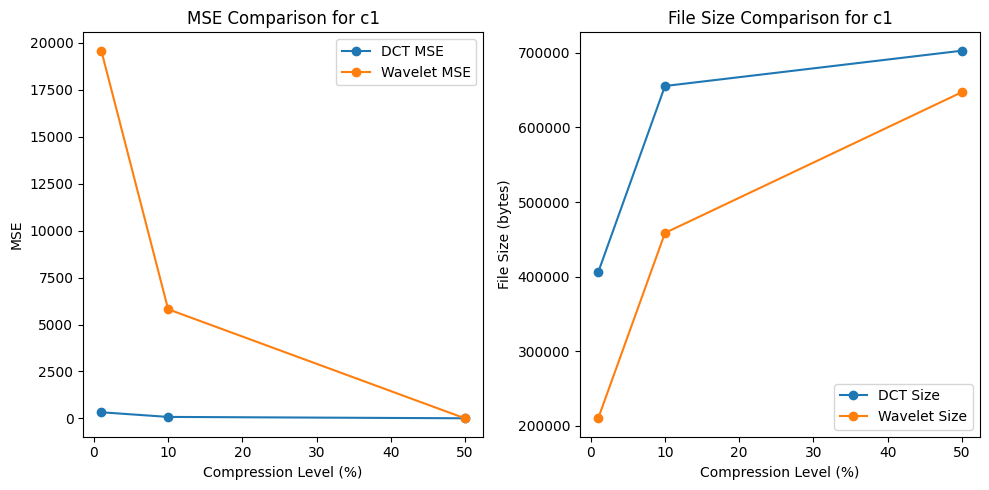

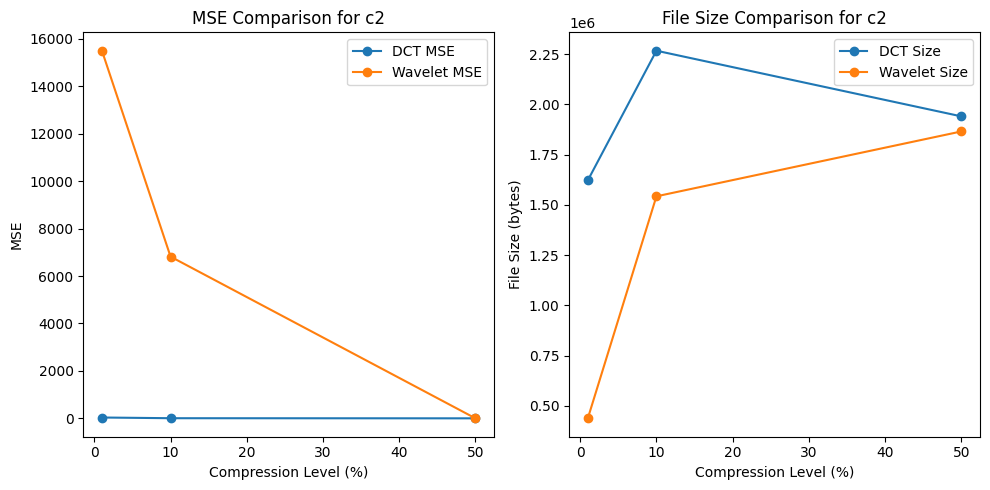

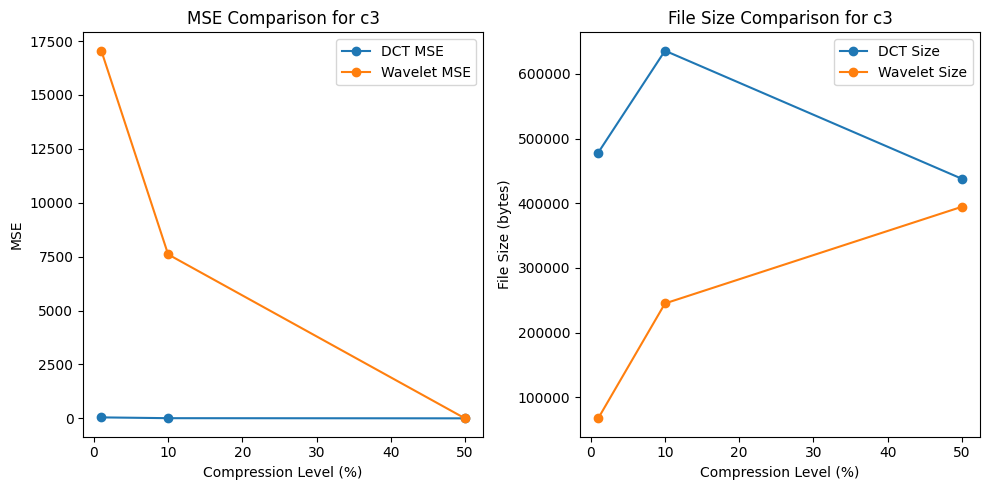

In [ ]:
import numpy as np
import pywt
import cv2
import os
from scipy.fftpack import dct, idct
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Paths to the images
image_paths = ["c1.jpg", "c2.jpg", "c3.jpg"]
output_folder = "compressed_images"
os.makedirs(output_folder, exist_ok=True)

# Function to apply DCT and IDCT
def apply_dct(image, n):
    dct_transformed = dct(dct(image.T, norm='ortho').T, norm='ortho')
    flattened = np.abs(dct_transformed).flatten()
    threshold = np.percentile(flattened, 100 - n)
    dct_transformed[np.abs(dct_transformed) < threshold] = 0
    idct_image = idct(idct(dct_transformed.T, norm='ortho').T, norm='ortho')
    return dct_transformed, idct_image

# Function to apply Haar Wavelet Transform and Inverse
def apply_wavelet(image, n):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    cA, (cH, cV, cD) = coeffs
    coeffs_flattened = np.abs(np.hstack((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten())))
    threshold = np.percentile(coeffs_flattened, 100 - n)

    # Apply threshold
    cA[np.abs(cA) < threshold] = 0
    cH[np.abs(cH) < threshold] = 0
    cV[np.abs(cV) < threshold] = 0
    cD[np.abs(cD) < threshold] = 0

    coeffs_compressed = (cA, (cH, cV, cD))
    reconstructed_image = pywt.waverec2(coeffs_compressed, 'haar')
    return coeffs_compressed, reconstructed_image

# Function to visualize images
def visualize_images(original, compressed, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(compressed, cmap='gray')
    plt.axis('off')
    plt.show()

# Compression levels
compression_levels = [1, 10, 50]
results = {}

# Process each image
for image_path in image_paths:
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Error reading {image_path}")
        continue

    results[image_name] = {}

    for n in compression_levels:
        # DCT Compression
        dct_compressed, dct_reconstructed = apply_dct(original_image, n)
        dct_mse = mean_squared_error(original_image, dct_reconstructed)
        dct_filename = f"{output_folder}/{image_name}_dct_{n}.jpg"
        cv2.imwrite(dct_filename, np.clip(dct_reconstructed, 0, 255).astype(np.uint8))

        # Visualize DCT Results
        visualize_images(original_image, dct_reconstructed, f"DCT Reconstructed N={n}%")

        # Wavelet Compression
        wavelet_compressed, wavelet_reconstructed = apply_wavelet(original_image, n)
        wavelet_mse = mean_squared_error(original_image, wavelet_reconstructed)
        wavelet_filename = f"{output_folder}/{image_name}_wavelet_{n}.jpg"
        cv2.imwrite(wavelet_filename, np.clip(wavelet_reconstructed, 0, 255).astype(np.uint8))

        # Visualize Wavelet Results
        visualize_images(original_image, wavelet_reconstructed, f"Wavelet Reconstructed N={n}%")

        results[image_name][n] = {
            "dct": {
                "mse": dct_mse,
                "size": os.path.getsize(dct_filename)
            },
            "wavelet": {
                "mse": wavelet_mse,
                "size": os.path.getsize(wavelet_filename)
            }
        }

# Display results
for image_name, data in results.items():
    print(f"Results for {image_name}:")
    for n, metrics in data.items():
        print(f"  Compression Level N={n}%:")
        print(f"    DCT -> MSE: {metrics['dct']['mse']:.4f}, Size: {metrics['dct']['size']} bytes")
        print(f"    Wavelet -> MSE: {metrics['wavelet']['mse']:.4f}, Size: {metrics['wavelet']['size']} bytes")

# Optional: Plot MSE and File Size Comparison
def plot_results(results):
    for image_name, data in results.items():
        compression_levels = list(data.keys())
        dct_mse = [data[n]['dct']['mse'] for n in compression_levels]
        wavelet_mse = [data[n]['wavelet']['mse'] for n in compression_levels]
        dct_size = [data[n]['dct']['size'] for n in compression_levels]
        wavelet_size = [data[n]['wavelet']['size'] for n in compression_levels]

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(compression_levels, dct_mse, label='DCT MSE', marker='o')
        plt.plot(compression_levels, wavelet_mse, label='Wavelet MSE', marker='o')
        plt.title(f"MSE Comparison for {image_name}")
        plt.xlabel("Compression Level (%)")
        plt.ylabel("MSE")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(compression_levels, dct_size, label='DCT Size', marker='o')
        plt.plot(compression_levels, wavelet_size, label='Wavelet Size', marker='o')
        plt.title(f"File Size Comparison for {image_name}")
        plt.xlabel("Compression Level (%)")
        plt.ylabel("File Size (bytes)")
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_results(results)
